In [1]:
import os
from PIL import Image, ImageFile
import math
import copy
import wandb
ImageFile.LOAD_TRUNCATED_IMAGES = True
import matplotlib.pyplot as plt # for plotting
import numpy as np # for transformation

import torch # PyTorch package
import torchvision # load datasets
import torchvision.transforms as transforms # transform data
from torch.autograd import Variable
import torch.cuda as cuda
import torch.nn as nn # basic building block for neural neteorks
import torch.nn.functional as F # import convolution functions like Relu
import torch.optim as optim # optimzer
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader


In [2]:
def checkImage(path):
    try:
        im = Image.open(path)
        return True
    except:
        return False
    pass

img_transforms = transforms.Compose([
    transforms.ColorJitter(brightness=.2, hue=.5),
    transforms.Resize((224,224)),
    transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                    std=[0.5, 0.5, 0.5] )
    ])

rotation = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomRotation(degrees=(0, 180)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                    std=[0.5, 0.5, 0.5] )
    ])

non_augmented = transforms.Compose([
    transforms.ColorJitter(brightness=.2, hue=0,contrast=.2,saturation=.2),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                    std=[0.5, 0.5, 0.5] )
    ])

def imshow(img):
  ''' function to show image '''
  img = img / 2 + 0.5 # unnormalize
  npimg = img.numpy() # convert to numpy objects
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()


In [3]:
base_dir = './dataset/'
print(os.listdir(base_dir))
for base in os.listdir(base_dir):
    if base == "train":
        train_data = torchvision.datasets.ImageFolder(root = os.path.join(base_dir,base), transform = img_transforms, is_valid_file = checkImage)
        rotation_data = torchvision.datasets.ImageFolder(root = os.path.join(base_dir,base), transform = rotation, is_valid_file = checkImage)
        original_data = torchvision.datasets.ImageFolder(root = os.path.join(base_dir,base), transform = non_augmented, is_valid_file = checkImage)
        new_train = train_data + original_data + rotation_data
    elif base == "val":
        val_data = torchvision.datasets.ImageFolder(root = os.path.join(base_dir,base), transform = img_transforms, is_valid_file = checkImage)
        original_data = torchvision.datasets.ImageFolder(root = os.path.join(base_dir,base), transform = non_augmented, is_valid_file = checkImage)
        new_val = val_data + original_data
    elif base == "test":
        test_data = torchvision.datasets.ImageFolder(root = os.path.join(base_dir,base), transform = img_transforms, is_valid_file = checkImage)
        original_data = torchvision.datasets.ImageFolder(root = os.path.join(base_dir,base), transform = non_augmented, is_valid_file = checkImage)
        new_test = test_data + original_data

print(train_data)
print(val_data)
print(test_data)

['.DS_Store', 'test', 'train', 'val']
Dataset ImageFolder
    Number of datapoints: 17
    Root location: ./dataset/train
    StandardTransform
Transform: Compose(
               ColorJitter(brightness=(0.8, 1.2), contrast=None, saturation=None, hue=(-0.5, 0.5))
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               RandomPerspective(p=1.0)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )
Dataset ImageFolder
    Number of datapoints: 8
    Root location: ./dataset/val
    StandardTransform
Transform: Compose(
               ColorJitter(brightness=(0.8, 1.2), contrast=None, saturation=None, hue=(-0.5, 0.5))
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               RandomPerspective(p=1.0)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )
Dataset ImageFolder
    Number of

In [4]:
#By default, PyTorch’s data loaders are set to a batch_size of 1.
BATCH_SIZE = 128
train_data_loader = torch.utils.data.DataLoader(new_train, batch_size = BATCH_SIZE)
val_data_loader  = torch.utils.data.DataLoader(new_val, batch_size = BATCH_SIZE) 
test_data_loader  = torch.utils.data.DataLoader(new_test, batch_size = BATCH_SIZE)

num_step =math.ceil(len(train_data_loader.dataset) / BATCH_SIZE)

tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2,
        2, 2, 2])


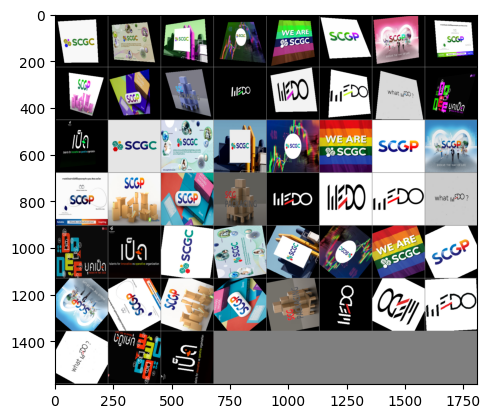

scgc scgc scgc scgc scgc scgp scgp scgp scgp scgp scgp wedo wedo wedo wedo wedo wedo scgc scgc scgc scgc scgc scgp scgp scgp scgp scgp scgp wedo wedo wedo wedo wedo wedo scgc scgc scgc scgc scgc scgp scgp scgp scgp scgp scgp wedo wedo wedo wedo wedo wedo


In [5]:
classes = ('scgc','scgp','wedo')

sample = next(iter(train_data_loader))
imgs, lbls = sample
print(lbls)

# call function on our images
imshow(torchvision.utils.make_grid(imgs))
print(' '.join('%s' % classes[lbls[j]] for j in range(len(imgs))))


In [6]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)
model.eval()

Using cache found in /Users/pongkornsettasompop/.cache/torch/hub/pytorch_vision_v0.10.0
/Users/pongkornsettasompop/anaconda3/envs/mi/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/pongkornsettasompop/anaconda3/envs/mi/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
class Net(nn.Module):
    ''' Models a simple Convolutional Neural Network'''
	
    def __init__(self, input_size = 150528):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 84)
        self.fc2 = nn.Linear(84, 50)
        self.fc3 = nn.Linear(50,3)
        pass
    
    def forward(self, x):
        x = x.view(-1, 150528)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        pass

net = Net()
print(net)

Net(
  (fc1): Linear(in_features=150528, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=3, bias=True)
)


In [8]:
 #wand setup
#"weightname":"S12_3-9_fir8-14"
#name=f"CNN_S12_3-9_fir8-14",
wandb.login()
wand = wandb.init(
      # Set the project where this run will be logged
      project="AR-classification", 
      # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
      name=f"CNN_S21_iir_LFRH_4ch", 
      # Track hyperparameters and run metadata
      # 0.0000001
      config={
      "learning_rate": 0.0001,
      "architecture": "CNN",
      "dataset": "Organization",
      "epochs": 500,
      "weightname":"CNN_1",
      "num_step_per_epoch" : num_step
      }
    )

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: pongkorn-set. Use `wandb login --relogin` to force relogin


In [9]:
config = wand.config
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=config.learning_rate)


In [10]:
def train(model, loader_train, loader_test, optimizer,criterion,device,wand,vail_loader= None,
          cross = False):
    # put model on cuda if not already
    device = torch.device(device)
    config = wand.config
    
    weights_name = config.weightname
    best_val_loss = + np.infty
    best_model = copy.deepcopy(model)
    train_loss = []
    valid_loss = [10,11]
    train_accuracy = []
    valid_accuracy = []
    
    old_loss = 100
    old_acc = 0
    valid_loss_vail = []
    
    for epoch in range(config.epochs):
        iter_loss = 0.0
        correct = 0
        iterations = 0

        model.train()

        for i, (items, classes) in enumerate(loader_train):
            items = Variable(items)
            classes = classes.type(torch.LongTensor)
            classes = Variable(classes)

            if cuda.is_available():
                items = items.to(device=device)
                classes = classes.to(device=device)

            optimizer.zero_grad()
            outputs = model(items)
            loss = criterion(outputs, classes)

            iter_loss += loss.item()
            loss.backward()
            optimizer.step()
            
            metrics = {"train/train_loss": loss}
            if i + 1 < config.num_step_per_epoch:
                # 🐝 Log train metrics to wandb 
                wand.log(metrics)
            
            #print(loss)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == classes.data).sum()
            iterations += 1

        train_loss.append(iter_loss/iterations)
        

        train_accuracy.append((100 * correct.float() / len(loader_train.dataset)))
        train_metrics = {"train/train_loss": iter_loss/iterations, 
                       "train/train_accuracy": (100 * correct.float() / len(loader_train.dataset))}
        
        wand.log({**metrics, **train_metrics})

        loss = 0.0
        correct = 0
        iterations = 0
        model.eval()
        
        for i, (items, classes) in enumerate(loader_test):
            items = Variable(items)
            classes = Variable(classes)
            
            if cuda.is_available():
                items = items.to(device=device)
                classes = classes.to(device=device)
            
            outputs = model(items)
            loss += criterion(outputs, classes).item()
            
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == classes.data).sum()
            
            iterations += 1
        
        valid_loss.append(loss/iterations)
        correct_scalar = np.array([correct.clone().cpu()])[0]
        valid_accuracy.append(correct_scalar / len(loader_test.dataset) * 100.0)
        
        val_metrics = {"val/val_loss": loss/iterations, 
                       "val/val_accuracy": correct_scalar / len(loader_test.dataset) * 100.0}
        wand.log({**metrics, **val_metrics})

        epoch_acc = correct.double()/len(loader_test.dataset)
        #and old_acc <= valid_accuracy[-1]
        if epoch+1 > 2 and valid_loss[-1] < old_loss :
                newpath = r'./save_weight/{}'.format(weights_name) 
                if not os.path.exists(newpath):
                    os.makedirs(newpath)
                torch.save(model.state_dict(),'./save_weight/{}/{:.4f}_{}_{:.4f}_{:.4f}.pth'.format(weights_name,valid_loss[-1],weights_name,valid_loss[-1],valid_accuracy[-1]))
                old_loss = valid_loss[-1]  
                old_acc = valid_accuracy[-1]
        if (epoch % 100) ==0:
            print ('Epoch %d/%d, Tr Loss: %.4f, Tr Acc: %.4f, Val Loss: %.4f, Val Acc: %.4f'
                       %(epoch+1, config.epochs, train_loss[-1], train_accuracy[-1], valid_loss[-1], valid_accuracy[-1]))
         
        if cross :
                loss_vail = 0.0
                correct_vail = 0
                iterations_vail = 0
                model.eval()

                for i, (items, classes) in enumerate(vail_loader):
                    classes = classes.type(torch.LongTensor)
                    items = Variable(items)
                    classes = Variable(classes)

                    if cuda.is_available():
                        items = items.to(device=device)
                        classes = classes.to(device=device)


                    outputs = model(items)
                    loss_vail += criterion(outputs, classes).item()

                    _, predicted = torch.max(outputs.data, 1)

                    correct_vail += (predicted == classes.data).sum()
                    #print("correct : {}".format(classes.data))
                    #print("predicted : {}".format(predicted))
                    iterations_vail += 1

                valid_loss_vail.append(loss_vail/iterations_vail)
                correct_scalar = np.array([correct_vail.clone().cpu()])[0]
                valid_accuracy.append(correct_scalar / len(vail_loader.dataset) * 100.0)
                vali_metrics = {"val/val_loss": loss_vail/iterations, 
                        "val/val_accuracy": correct_scalar / len(loader_test.dataset) * 100.0}
                wand.log({**metrics, **vali_metrics})
                if (epoch % 100) ==0:
                    print ('Val Loss: {0}, Val Acc: {1}'.format(valid_loss_vail[-1], valid_accuracy[-1]))

    return train_loss,valid_loss,train_accuracy,valid_accuracy



In [11]:
train_loss,valid_loss,train_accuracy,valid_accuracy =train(
    model = net,
    loader_train = train_data_loader,
    loader_test =test_data_loader,
    vail_loader = val_data_loader,
    optimizer = optimizer  ,
    criterion = criterion ,
    device = 'cuda',
    wand = wand
)


wandb.alert(
            title='Finish',
            text=f'Finishing training',
        )

Epoch 1/500, Tr Loss: 1.1203, Tr Acc: 29.4118, Val Loss: 1.1791, Val Acc: 33.3333
Epoch 101/500, Tr Loss: 0.3286, Tr Acc: 84.3137, Val Loss: 2.3024, Val Acc: 25.0000
Epoch 201/500, Tr Loss: 0.1615, Tr Acc: 92.1569, Val Loss: 2.4961, Val Acc: 33.3333
Epoch 301/500, Tr Loss: 0.2046, Tr Acc: 92.1569, Val Loss: 3.2921, Val Acc: 33.3333
Epoch 401/500, Tr Loss: 0.1460, Tr Acc: 94.1176, Val Loss: 3.4455, Val Acc: 41.6667


In [12]:
# NUM_EPOCH = 500
# for epoch in range(NUM_EPOCH):  # loop over the dataset multiple times

#     running_loss = 0.0
#     for i, (items, classes) in enumerate(train_data_loader):
#         # get the inputs; data is a list of [inputs, labels]

#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = net(data)
#         loss = criterion(outputs, label)
#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()
#     if epoch % 10 == 0:    # print every 2000 mini-batches
#         print('[%d, %5d] loss: %.3f' %
#             (epoch + 1, i + 1, running_loss / 2000))
#         running_loss = 0.0

In [26]:
PATH = f"./save_weight/CNN_1/1.0620_CNN_1_1.0620_50.0000.pth"
# # reload
net = Net()
net.load_state_dict(torch.load(PATH))
# torch.save(net.state_dict(), PATH)


<All keys matched successfully>

In [27]:
# # reload
# net = Net()
# net.load_state_dict(torch.load(PATH))

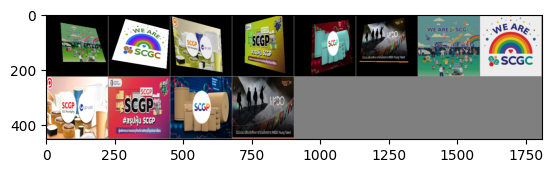

GroundTruth:  scgc scgc scgp scgp scgp wedo scgc scgc scgp scgp scgp wedo
Predicted:  wedo scgp scgp wedo wedo wedo wedo scgc scgc scgc scgc wedo


In [33]:
classes = ('scgc','scgp','wedo')
sample = next(iter(test_data_loader))
imgs, lbls = sample

# print images
imshow(torchvision.utils.make_grid(imgs))
print('GroundTruth: ', ' '.join('%s' % classes[lbls[j]] for j in  range(len(imgs))))

outputs = net(imgs)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%s' % classes[predicted[j]]
                              for j in range(len(imgs))))

In [34]:
correct = 0
total = 0
with torch.no_grad():
    for data in val_data_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        print(labels)
        print(predicted)
        
        print(total)
        print(correct)

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

tensor([0, 0, 0, 1, 1, 2, 2, 2, 0, 0, 0, 1, 1, 2, 2, 2])
tensor([2, 1, 1, 1, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2])
16
10
Accuracy of the network on the 10000 test images: 62 %
